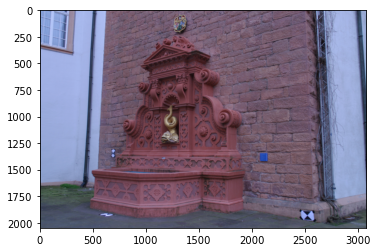

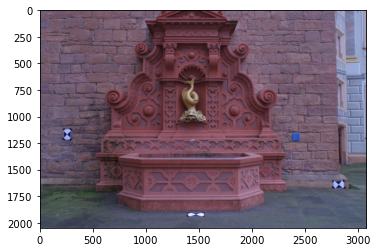

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pymagsac
from time import time

img1 = cv2.cvtColor(cv2.imread('../data/essential_matrix/fountain1.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../data/essential_matrix/fountain2.jpg'), cv2.COLOR_BGR2RGB)
K1 = np.loadtxt('../data/essential_matrix/fountain1.K')
K2 = np.loadtxt('../data/essential_matrix/fountain2.K')
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [3]:
#We will detect ORB features and match them with cross-check test
det = cv2.ORB_create(10000)    
kps1, descs1 = det.detectAndCompute(img1,None)
kps2, descs2 = det.detectAndCompute(img2,None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

tentatives = bf.match(descs1,descs2)

In [4]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, tentatives, img1, img2, mask):
    matchesMask = mask.ravel().tolist()
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,img2,kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(img_out)
    return

In [5]:
img1.shape

(2048, 3072, 3)

Note that the inlier number does not determine the quality of the solution since MAGSAC and MAGSAC++ does not return inliers. The ones shown are selected by using a dummy threshold.
341.0 inliers found
0.256314754486084 sec cv2
603.0 inliers found
0.11070537567138672 sec magsac++
606.0 inliers found
0.11269259452819824 sec magsac


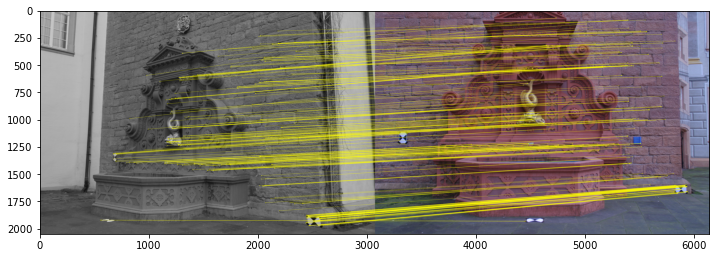

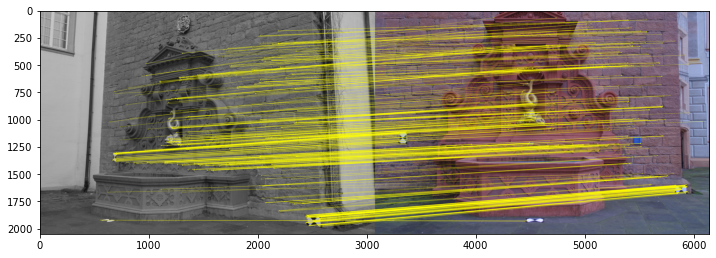

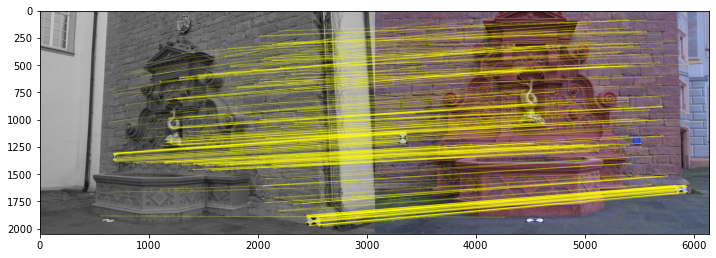

In [6]:

def verify_cv2_ess(kps1, kps2, tentatives, K1, K2, h1, w1, h2, w2):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    
    # Normalize the threshold
    threshold = 0.75
    avgDiagonal = (K1[0][0] + K1[1][1] + K2[0][0] + K2[1][1]) / 4; 
    normalizedThreshold = threshold / avgDiagonal;
            
    # Normalize the point coordinates
    normalizedSourcePoints = cv2.undistortPoints(np.expand_dims(src_pts, axis=1), cameraMatrix=K1, distCoeffs=None)
    normalizedDestinationPoints = cv2.undistortPoints(np.expand_dims(dst_pts, axis=1), cameraMatrix=K2, distCoeffs=None)
    
    # Estimate the essential matrix from the normalized coordinates
    # using the normalized threshold.
    E, mask = cv2.findEssentialMat(normalizedSourcePoints, 
                                   normalizedDestinationPoints, 
                                   focal=1.0, 
                                   pp=(0., 0.),
                                   method=cv2.RANSAC, 
                                   prob=0.99,
                                   threshold=normalizedThreshold)

    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

def verify_pymagsac_ess(kps1, kps2, tentatives, K1, K2, use_magsac_plus_plus):
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    E, mask = pymagsac.findEssentialMatrix(
        np.ascontiguousarray(src_pts), 
        np.ascontiguousarray(dst_pts), 
        np.ascontiguousarray(K1), 
        np.ascontiguousarray(K2), 
        use_magsac_plus_plus,
        2.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

print("Note that the inlier number does not determine the quality of the solution since MAGSAC and MAGSAC++ does not return inliers. The ones shown are selected by using a dummy threshold.")

t=time()
cv2_E, gc_cv2_mask = verify_cv2_ess(kps1, kps2, tentatives, K1, K2, img1.shape[0],img1.shape[1],
                                   img2.shape[0], img2.shape[1])
print (time()-t, 'sec cv2')

t=time()
magpp_E, magpp_E_mask = verify_pymagsac_ess(kps1, kps2, tentatives, K1, K2, True)
print (time()-t, 'sec magsac++')

t=time()
mag_E, mag_E_mask = verify_pymagsac_ess(kps1, kps2, tentatives, K1, K2, False)
print (time()-t, 'sec magsac')

draw_matches(kps1, kps2, tentatives, img1, img2, gc_cv2_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, magpp_E_mask)
draw_matches(kps1, kps2, tentatives, img1, img2, mag_E_mask)


Note: the number of inliers does not determine the quality of the solution. 
    This adaptive inlier selection algorithm selects the set of inliers such that they lead 
    to the most similar model after LSQ fitting to the estimated one.
    This might be useful e.g. in SfM pipelines when using MAGSAC or MAGSAC++.
    If more inliers are needed, parameter 'minimum_required_inliers' should be set higher
47 inliers are found by the adaptive strategy
8.386866011668131e-10 px is the best threshold


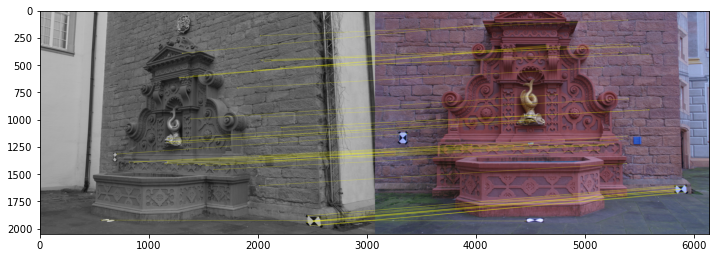

In [33]:
def adaptive_inlier_selection(kps1, kps2, K1, K2, tentatives, model, maximum_threshold, minimum_required_inliers):
    
    K1inv = np.linalg.inv(K1)
    K2inv = np.linalg.inv(K2)
    
    src_pts = np.float32([ (np.dot(K1inv, np.append(kps1[m.queryIdx].pt, 1)) / np.dot(K1inv, np.append(kps1[m.queryIdx].pt, 1))[2])[:2] for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ (np.dot(K2inv, np.append(kps2[m.trainIdx].pt, 1)) / np.dot(K2inv, np.append(kps2[m.trainIdx].pt, 1))[2])[:2] for m in tentatives ]).reshape(-1,2)
    
    mask, inlier_number, best_threshold = pymagsac.adaptiveInlierSelection(
        np.ascontiguousarray(src_pts), 
        np.ascontiguousarray(dst_pts), 
        np.ascontiguousarray(model), 
        maximumThreshold = maximum_threshold, # An upper bound for the threshold, this speeds up the procedure, but it should work with infinity as well
        problemType = 2, # 2 stands for essential matrix fitting
        minimumInlierNumber = minimum_required_inliers)
    
    return mask, inlier_number, best_threshold

mask, inlier_number, best_threshold = adaptive_inlier_selection(kps1, kps2, K1, K2, tentatives, cv2_E, 10.0, 20)
draw_matches(kps1, kps2, tentatives, img1, img2, mask)

print("""Note: the number of inliers does not determine the quality of the solution. 
    This adaptive inlier selection algorithm selects the set of inliers such that they lead 
    to the most similar model after LSQ fitting to the estimated one.
    This might be useful e.g. in SfM pipelines when using MAGSAC or MAGSAC++.
    If more inliers are needed, parameter 'minimum_required_inliers' should be set higher""")
print(inlier_number, 'inliers are found by the adaptive strategy')
print(best_threshold, 'px is the best threshold')